In [223]:
import json
import logging
import os
import random
from copy import deepcopy
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
from room_env.utils import write_json, read_json


def find_connected_nodes(graph):
    def dfs(node, row, col):
        if (
            row < 0
            or col < 0
            or row >= len(graph)
            or col >= len(graph[0])
            or graph[row][col] == 0
        ):
            return

        connected_nodes.append((row, col))
        graph[row][col] = 0  # Mark the node as visited

        # Check the neighbors
        dfs(node, row - 1, col)  # Up
        dfs(node, row + 1, col)  # Down
        dfs(node, row, col - 1)  # Left
        dfs(node, row, col + 1)  # Right

    connected_components = []
    for row in range(len(graph)):
        for col in range(len(graph[row])):
            if graph[row][col] == 1:
                connected_nodes = []
                dfs(1, row, col)
                if connected_nodes:
                    connected_components.append(connected_nodes)

    return connected_components


class RoomCreator:
    def __init__(
        self,
        grid_length: int,
        num_static_objects: int,
        num_independent_objects: int,
        num_dependent_objects: int,
        room_prob: float,
        file_path: str,
    ) -> None:
        """Create rooms with objects.

        Args
        ----
        grid_length: grid legnth
        num_static_objects: Number of static objects to create.
        num_independent_objects: Number of independent objects to create.
        num_dependent_objects: Number of dependent objects to create.
        room_prob: probability of a cell being a room.
        file_path: path to save the room configuration.

        """
        self.grid_length = grid_length
        self.num_static_objects = num_static_objects
        self.num_independent_objects = num_independent_objects
        self.num_dependent_objects = num_dependent_objects
        self.room_prob = room_prob
        self.file_path = file_path

        self._create_grid_world()
        self._create_room_config()
        self._create_object_init_config()
        self._create_object_transition_config()
        self._give_fake_names()
        write_json(
            {
                "room_config": self.room_config_str,
                "object_transition_config": self.object_transition_config_str,
                "object_init_config": self.object_init_config_str,
            },
            self.file_path,
        )

    def _create_grid_world(self) -> None:
        rows = self.grid_length
        cols = self.grid_length
        self.grid = [
            [1 if random.random() < self.room_prob else 0 for _ in range(cols)]
            for _ in range(rows)
        ]

        self.connected_components = find_connected_nodes(deepcopy(self.grid))
        for i, component in enumerate(self.connected_components):
            print(f"Connected Component {i + 1}: {component}")

        self.room_indexes = max(
            enumerate(self.connected_components), key=lambda x: len(x[1])
        )[1]
        self.room_indexes.sort(key=lambda x: x[1])
        self.room_indexes.sort(key=lambda x: x[0])
        self.grid = [[0 for _ in range(cols)] for _ in range(rows)]
        for i in range(rows):
            for j in range(cols):
                if (i, j) in self.room_indexes:
                    self.grid[i][j] = 1

        self.num_rooms = len(self.room_indexes)
        # self._load_names("./room_env/data/names-v2.json")

    def _create_room_config(self) -> None:
        """Create a room configuration."""
        self.room_config = {
            i: {"north": "wall", "east": "wall", "south": "wall", "west": "wall"}
            for i in range(self.num_rooms)
        }
        for i, (row_idx, col_idx) in enumerate(self.room_indexes):
            north_idx = (row_idx - 1, col_idx)
            east_idx = (row_idx, col_idx + 1)
            south_idx = (row_idx + 1, col_idx)
            west_idx = (row_idx, col_idx - 1)

            if north_idx in self.room_indexes:
                self.room_config[i]["north"] = self.room_indexes.index(north_idx)
            if east_idx in self.room_indexes:
                self.room_config[i]["east"] = self.room_indexes.index(east_idx)
            if south_idx in self.room_indexes:
                self.room_config[i]["south"] = self.room_indexes.index(south_idx)
            if west_idx in self.room_indexes:
                self.room_config[i]["west"] = self.room_indexes.index(west_idx)

    def _create_object_init_config(self) -> None:
        """Create an object initialization configuration."""
        self.object_init_config = {}
        self.object_init_config["static"] = {
            num: {
                i: num_
                for i, num_ in enumerate(
                    self._generate_categorical_distribution(self.num_rooms)
                )
            }
            for num in range(self.num_static_objects)
        }

        self.object_init_config["independent"] = {
            num: {
                i: num_
                for i, num_ in enumerate(
                    self._generate_categorical_distribution(self.num_rooms)
                )
            }
            for num in range(self.num_independent_objects)
        }

        self.object_init_config["dependent"] = {
            num: {
                i: num_
                for i, num_ in enumerate(
                    self._generate_categorical_distribution(self.num_rooms)
                )
            }
            for num in range(self.num_dependent_objects)
        }
        self.object_init_config["agent"] = {
            "agent": {
                i: num_
                for i, num_ in enumerate(
                    self._generate_categorical_distribution(self.num_rooms)
                )
            }
        }

    def _create_object_transition_config(self) -> None:
        """Create an object transition configuration."""
        self.object_transition_config = {}
        self.object_transition_config["static"] = {
            i: None for i in range(self.num_static_objects)
        }
        self.object_transition_config["independent"] = {
            i: {
                j: {"north": 0, "east": 0, "south": 0, "west": 0, "west": 0, "stay": 0}
                for j in range(self.num_rooms)
            }
            for i in range(self.num_independent_objects)
        }
        for object_num, room_num_nesws in self.object_transition_config[
            "independent"
        ].items():
            for room_num, nesw in room_num_nesws.items():
                for direction, prob in nesw.items():
                    if direction == "stay":
                        nesw[direction] = random.random()
                    else:
                        if self.room_config[room_num][direction] != "wall":
                            nesw[direction] = random.random()

                denominator = sum(nesw.values())
                for direction, prob in nesw.items():
                    nesw[direction] = nesw[direction] / denominator

        self.object_transition_config["dependent"] = {
            i: {j: random.random() for j in range(self.num_independent_objects)}
            for i in range(self.num_dependent_objects)
        }
        self.object_transition_config["agent"] = {"agent": None}

    def _give_fake_names(self) -> None:
        """Give fake names to the rooms and objects."""
        names = read_json("./room_env/data/names-v2.json")
        self.names = {}
        self.names["room"] = random.choices(names["rooms"], k=self.num_rooms)
        self.names["static_objects"] = random.choices(
            names["static_objects"], k=self.num_static_objects
        )
        self.names["independent_objects"] = random.choices(
            names["independent_objects"], k=self.num_independent_objects
        )
        self.names["dependent_objects"] = random.choices(
            names["dependent_objects"], k=self.num_dependent_objects
        )

        self.room_config_str = {}
        for i in range(self.num_rooms):
            self.room_config_str[self.names["room"][i]] = deepcopy(self.room_config[i])
            self.room_config_str[self.names["room"][i]] = {
                k: self.names["room"][v] if v != "wall" else v
                for k, v in self.room_config_str[self.names["room"][i]].items()
            }

        self.object_init_config_str = {}

        self.object_init_config_str["static"] = {
            self.names["static_objects"][num]: {
                self.names["room"][i]: num_ for i, num_ in num_dist.items()
            }
            for num, num_dist in self.object_init_config["static"].items()
        }

        self.object_init_config_str["independent"] = {
            self.names["independent_objects"][num]: {
                self.names["room"][i]: num_ for i, num_ in num_dist.items()
            }
            for num, num_dist in self.object_init_config["independent"].items()
        }

        self.object_init_config_str["dependent"] = {
            self.names["dependent_objects"][num]: {
                self.names["room"][i]: num_ for i, num_ in num_dist.items()
            }
            for num, num_dist in self.object_init_config["dependent"].items()
        }

        self.object_init_config_str["agent"] = {
            "agent": {
                self.names["room"][room_num]: val
                for room_num, val in self.object_init_config["agent"]["agent"].items()
            }
        }

        self.object_transition_config_str = {}

        self.object_transition_config_str["static"] = {
            self.names["static_objects"][num]: None
            for num in self.object_transition_config["static"]
        }

        self.object_transition_config_str["independent"] = {
            self.names["independent_objects"][num]: {
                self.names["room"][i]: num_ for i, num_ in num_dist.items()
            }
            for num, num_dist in self.object_transition_config["independent"].items()
        }

        self.object_transition_config_str["dependent"] = {
            self.names["dependent_objects"][num]: {
                self.names["independent_objects"][i]: num_
                for i, num_ in num_dist.items()
            }
            for num, num_dist in self.object_transition_config["dependent"].items()
        }
        self.object_transition_config_str["agent"] = self.object_transition_config[
            "agent"
        ]

    def _generate_categorical_distribution(self, num_categories: int) -> List[float]:
        """Generate a categorical distribution."""
        dist = [random.random() for _ in range(num_categories)]
        dist = [x / sum(dist) for x in dist]
        return dist

    def visualize_grid(self):
        rows = len(self.grid)
        cols = len(self.grid[0])

        # Create a figure and axis for plotting
        fig, ax = plt.subplots()

        # Define colors for different grid cell contents
        color_mapping = {
            # "obstacle": "black",
            # "goal": "green",
            # "start": "blue",
            # "room": "gray",
            "empty": "white",
        }

        for row in range(rows):
            for col in range(cols):
                cell_content = self.grid[row][col]
                if cell_content != 0:
                    color = "gray"
                else:
                    color = "white"
                ax.add_patch(
                    plt.Rectangle((col, rows - 1 - row), 1, 1, facecolor=color)
                )

        ax.set_aspect("equal")
        ax.set_xticks(range(cols + 1))
        ax.set_yticks(range(rows + 1))
        ax.grid(which="both")

        plt.show()

Connected Component 1: [(0, 2)]
Connected Component 2: [(1, 0), (1, 1), (2, 1)]


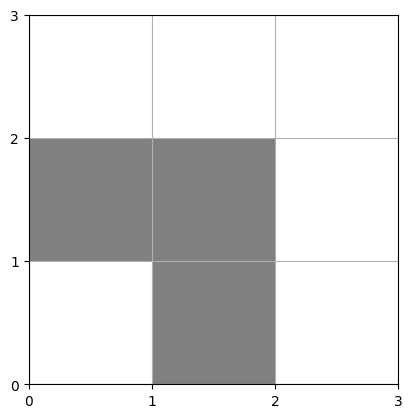

In [224]:
room_creator = RoomCreator(
    grid_length=3,
    num_static_objects=2,
    num_independent_objects=3,
    num_dependent_objects=4,
    room_prob=0.5,
    file_path="./room_env/data/room-config-dev-v2.json",
)
# room_creator.grid
room_creator.visualize_grid()

In [204]:
room_creator.room_indexes

[(1, 0), (2, 0), (2, 1), (2, 2)]

In [205]:
room_creator.room_config

{0: {'north': 'wall', 'east': 'wall', 'south': 1, 'west': 'wall'},
 1: {'north': 0, 'east': 2, 'south': 'wall', 'west': 'wall'},
 2: {'north': 'wall', 'east': 3, 'south': 'wall', 'west': 1},
 3: {'north': 'wall', 'east': 'wall', 'south': 'wall', 'west': 2}}

In [206]:
room_creator.num_rooms

4

In [219]:
room_creator.object_init_config

{'static': {0: {0: 0.23919903317557664,
   1: 0.2230685504122638,
   2: 0.1750216990548149,
   3: 0.15960147113500592,
   4: 0.19128958228427972,
   5: 0.011819663938059105},
  1: {0: 0.06370543066716057,
   1: 0.3567366455255768,
   2: 0.027048003975509754,
   3: 0.1960470262969807,
   4: 0.35260281482572003,
   5: 0.0038600787090520843}},
 'independent': {0: {0: 0.17901102358498688,
   1: 0.03216910569927823,
   2: 0.14980846093341765,
   3: 0.235350313843322,
   4: 0.16768644766360064,
   5: 0.2359746482753946},
  1: {0: 0.19885163850849627,
   1: 0.13896629816193018,
   2: 0.2214898304520529,
   3: 0.2393508063457901,
   4: 0.09913264498383363,
   5: 0.10220878154789682},
  2: {0: 0.15473682472888634,
   1: 0.13926614559400893,
   2: 0.2470992802609157,
   3: 0.24050402927952952,
   4: 0.19154274912078104,
   5: 0.02685097101587839}},
 'dependent': {0: {0: 0.383938892232757,
   1: 0.04031896087722111,
   2: 0.2113415031235499,
   3: 0.11835843654556713,
   4: 0.005961289596126025,


In [222]:
room_creator.object_init_config["agent"]["agent"]

{0: 0.1508110107710625,
 1: 0.01173928939743654,
 2: 0.13825555633077885,
 3: 0.03784217382504181,
 4: 0.346804106895478,
 5: 0.3145478627802023}

In [208]:
room_creator.object_init_config_str

{'static': {'platform_bed': {'cosmic_comic_con_concourse': 0.15616106870486807,
   'cosmic_cosmos_chamber': 0.35514011234824855,
   'polar_bear_patio': 0.06958128859520017,
   'mysterious_martian_museum': 0.4191175303516832},
  'filing_cabinet': {'cosmic_comic_con_concourse': 0.04310260266399426,
   'cosmic_cosmos_chamber': 0.11642767533957538,
   'polar_bear_patio': 0.5244166715737568,
   'mysterious_martian_museum': 0.31605305042267356}},
 'independent': {'charles': {'cosmic_comic_con_concourse': 0.3064918317039166,
   'cosmic_cosmos_chamber': 0.03828004047756188,
   'polar_bear_patio': 0.24161673904696557,
   'mysterious_martian_museum': 0.41361138877155595},
  'teresa': {'cosmic_comic_con_concourse': 0.5318033712139555,
   'cosmic_cosmos_chamber': 0.1539246953088196,
   'polar_bear_patio': 0.2088499439725976,
   'mysterious_martian_museum': 0.10542198950462733},
  'mark': {'cosmic_comic_con_concourse': 0.4276567122473487,
   'cosmic_cosmos_chamber': 0.33249404054630993,
   'polar_b

In [209]:
room_creator.room_config

{0: {'north': 'wall', 'east': 'wall', 'south': 1, 'west': 'wall'},
 1: {'north': 0, 'east': 2, 'south': 'wall', 'west': 'wall'},
 2: {'north': 'wall', 'east': 3, 'south': 'wall', 'west': 1},
 3: {'north': 'wall', 'east': 'wall', 'south': 'wall', 'west': 2}}

In [184]:
room_creator.room_config_str

{'whimsical_waterfall_workshop': {'north': 'wall',
  'east': 'dreamy_dreamcatcher_den',
  'south': 'whimsical_whale_watching_room',
  'west': 'wall'},
 'dreamy_dreamcatcher_den': {'north': 'wall',
  'east': 'wall',
  'south': 'steampunk_sorcery_sanctum',
  'west': 'whimsical_waterfall_workshop'},
 'whimsical_whale_watching_room': {'north': 'whimsical_waterfall_workshop',
  'east': 'steampunk_sorcery_sanctum',
  'south': 'wall',
  'west': 'wall'},
 'steampunk_sorcery_sanctum': {'north': 'dreamy_dreamcatcher_den',
  'east': 'wall',
  'south': 'whimsical_wizard_workshop',
  'west': 'whimsical_whale_watching_room'},
 'whimsical_wizard_workshop': {'north': 'steampunk_sorcery_sanctum',
  'east': 'wall',
  'south': 'wall',
  'west': 'wall'}}

In [185]:
room_creator.object_transition_config_str

{'static': {'mattress': None, 'credenza': None},
 'independent': {'joshua': {'whimsical_waterfall_workshop': 0.14861298173304088,
   'dreamy_dreamcatcher_den': 0.16128921886756112,
   'whimsical_whale_watching_room': 0.24629352091985393,
   'steampunk_sorcery_sanctum': 0.4214875662765193,
   'whimsical_wizard_workshop': 0.0223167122030248},
  'angela': {'whimsical_waterfall_workshop': 0.15546066684840854,
   'dreamy_dreamcatcher_den': 0.26641535586184906,
   'whimsical_whale_watching_room': 0.22511239235809635,
   'steampunk_sorcery_sanctum': 0.33842907532076144,
   'whimsical_wizard_workshop': 0.014582509610884597},
  'pamela': {'whimsical_waterfall_workshop': 0.26064341064885255,
   'dreamy_dreamcatcher_den': 0.1424145509806307,
   'whimsical_whale_watching_room': 0.20285090707081407,
   'steampunk_sorcery_sanctum': 0.24303542432916164,
   'whimsical_wizard_workshop': 0.15105570697054105}},
 'dependent': {'pestle_and_mortar': {'joshua': 0.3699867913436099,
   'angela': 0.839150649586

In [186]:
room_creator.object_transition_config

{'static': {0: None, 1: None},
 'independent': {0: {0: {'north': 0.0,
    'east': 0.28323042240954033,
    'south': 0.2454444609196356,
    'west': 0.0,
    'stay': 0.471325116670824},
   1: {'north': 0.0,
    'east': 0.0,
    'south': 0.6027803640767897,
    'west': 0.056284052197647025,
    'stay': 0.34093558372556326},
   2: {'north': 0.26385050005078375,
    'east': 0.3527225392056188,
    'south': 0.0,
    'west': 0.0,
    'stay': 0.3834269607435974},
   3: {'north': 0.19071850411590704,
    'east': 0.0,
    'south': 0.32867625785556476,
    'west': 0.38679661881444216,
    'stay': 0.09380861921408615},
   4: {'north': 0.4716565069295895,
    'east': 0.0,
    'south': 0.0,
    'west': 0.0,
    'stay': 0.5283434930704105}},
  1: {0: {'north': 0.0,
    'east': 0.22156974832498574,
    'south': 0.39729453554145827,
    'west': 0.0,
    'stay': 0.3811357161335561},
   1: {'north': 0.0,
    'east': 0.0,
    'south': 0.13520472237137499,
    'west': 0.5267975282186231,
    'stay': 0.337

In [164]:
import random
import gymnasium as gym

room_size = {
    "room_config": {
        "officeroom": {
            "north": "wall",
            "east": "wall",
            "south": "wall",
            "west": "wall",
        }
    },
    "object_transition_config": {
        "static": {"desk": None},
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": None}},
    },
    "object_init_config": {
        "static": {
            "desk": {"officeroom": 1},
        },
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": 1.0}},
    },
}
config = {
    "question_prob": 1.0,
    "seed": random.randint(0, 100000),
    "terminates_at": 9,
    "randomize_observations": True,
    "room_size": room_size,
}
env = gym.make("room_env:RoomEnv-v2", **config)

observations, info = env.reset()

/home/tk/.virtualenvs/human-memory/lib/python3.10/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


AssertionError: Agent objects do not move by itself.

In [22]:
observations

{'self': ['agent', 'atlocation', 'officeroom', 0],
 'room': [['officeroom', 'south', 'wall', 0],
  ['desk', 'atlocation', 'officeroom', 0],
  ['officeroom', 'east', 'wall', 0],
  ['officeroom', 'north', 'wall', 0],
  ['officeroom', 'west', 'wall', 0]],
 'question': ['desk', 'atlocation', '?', 0]}

In [1]:
import gymnasium as gym
import random

env = gym.make("room_env:RoomEnv-v2")
(obs, question), info = env.reset()
observations = []
questions = []
infos = []
actions = []
rewards = []
observations.append(obs)
questions.append(question)
infos.append(info)
while True:
    action_qa = question[0]
    action_explore = random.choice(["north", "east", "south", "west", "stay"])
    (obs, question), reward, done, truncated, info = env.step(("wall", action_explore))

    observations.append(obs)
    questions.append(question)
    infos.append(info)
    actions.append((action_qa, action_explore))
    rewards.append(reward)
    if done:
        break

print(len(observations), len(questions), len(infos), len(actions), len(rewards))

101 101 101 100 100


/home/tk/.virtualenvs/human-memory/lib/python3.9/site-packages/gymnasium/envs/registration.py:491: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
/home/tk/.virtualenvs/human-memory/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:197: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/home/tk/.virtualenvs/human-memory/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/home/tk/.virtualenvs/human-memory/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:156: UserWarning: WARN: The obs returned by the `res

In [8]:
import gymnasium as gym
import random

from room_env.envs.room2 import *

room_size = {
    "room_config": {
        "officeroom": {
            "north": "wall",
            "east": "livingroom",
            "south": "wall",
            "west": "wall",
        },
        "livingroom": {
            "north": "wall",
            "east": "wall",
            "south": "wall",
            "west": "officeroom",
        },
    },
    "object_transition_config": {
        "static": {"desk": None},
        "independent": {
            "tae": {
                "officeroom": {
                    "north": 0,
                    "east": 1.0,
                    "south": 0,
                    "west": 0,
                    "stay": 0,
                },
                "livingroom": {
                    "north": 0,
                    "east": 0,
                    "south": 0,
                    "west": 1.0,
                    "stay": 0,
                },
            },
        },
        "dependent": {
            "laptop": {"tae": 1.0},
        },
        "agent": {"agent": {"officeroom": None, "livingroom": None}},
    },
    "object_init_config": {
        "static": {
            "desk": {"officeroom": 1, "livingroom": 0},
        },
        "independent": {
            "tae": {"officeroom": 1.0, "livingroom": 0},
        },
        "dependent": {
            "laptop": {"officeroom": 1.0, "livingroom": 0},
        },
        "agent": {"agent": {"officeroom": 1.0, "livingroom": 0, "bedroom": 0}},
    },
}
config = {
    "question_prob": 1.0,
    "seed": random.randint(0, 100000),
    "terminates_at": 99,
    "room_size": room_size,
}
env = gym.make("room_env:RoomEnv-v2", **config)
(observations_, question), info = env.reset()

In [9]:
question, info

(['?', 'atlocation', 'officeroom', 0], {})

In [10]:
env.step(("desk", "east"))

(([['agent', 'atlocation', 'livingroom', 1],
   ['tae', 'atlocation', 'livingroom', 1],
   ['laptop', 'atlocation', 'livingroom', 1],
   ['livingroom', 'north', 'wall', 1],
   ['livingroom', 'east', 'wall', 1],
   ['livingroom', 'south', 'wall', 1],
   ['livingroom', 'west', 'officeroom', 1]],
  ['?', 'atlocation', 'livingroom', 1]),
 1,
 False,
 False,
 {'answers': ['desk', 'tae', 'laptop'], 'timestamp': 0})

In [11]:
env.step(("tae", "west"))

(([['agent', 'atlocation', 'officeroom', 2],
   ['desk', 'atlocation', 'officeroom', 2],
   ['tae', 'atlocation', 'officeroom', 2],
   ['laptop', 'atlocation', 'officeroom', 2],
   ['officeroom', 'north', 'wall', 2],
   ['officeroom', 'east', 'livingroom', 2],
   ['officeroom', 'south', 'wall', 2],
   ['officeroom', 'west', 'wall', 2]],
  ['desk', 'atlocation', '?', 2]),
 1,
 False,
 False,
 {'answers': ['tae', 'laptop'], 'timestamp': 1})

In [20]:
{"answers": ["agent", "desk", "tae", "laptop"], "timestamp": 0} == {
    "answers": ["agent", "desk", "tae", "laptop"],
    "timestamp": 0,
}

True

In [12]:
observations, question

([[['agent', 'atlocation', 'officeroom', 0],
   ['desk', 'atlocation', 'officeroom', 0],
   ['tae', 'atlocation', 'officeroom', 0],
   ['laptop', 'atlocation', 'officeroom', 0],
   ['officeroom', 'north', 'wall', 0],
   ['officeroom', 'east', 'livingroom', 0],
   ['officeroom', 'south', 'wall', 0],
   ['officeroom', 'west', 'wall', 0]]],
 ['?', 'atlocation', 'officeroom', 0])

In [5]:
env.observations, env.question

([['bedroom', 'north', 'livingroom', 100],
  ['bedroom', 'east', 'wall', 100],
  ['bedroom', 'south', 'wall', 100],
  ['bedroom', 'west', 'wall', 100],
  ['bed', 'atlocation', 'bedroom', 100],
  ['michael', 'atlocation', 'bedroom', 100],
  ['vincent', 'atlocation', 'bedroom', 100],
  ['headset', 'atlocation', 'bedroom', 100],
  ['agent', 'atlocation', 'bedroom', 100]],
 ['table', '?', 'livingroom', 100])

In [39]:
class Foo:
    def __init__(self, arg) -> None:
        self.arg = arg

    def get_arg(self):
        return self.arg


foo = Foo({"arg": "foo"})
bar = foo.get_arg()
foo.arg = {"arg": "bar"}

foo.arg, bar

({'arg': 'bar'}, {'arg': 'foo'})

In [26]:
foo = ["foo"]
bar = {"answers": foo}

bar["answers"].append("bar")


foo, bar

(['foo', 'bar'], {'answers': ['foo', 'bar']})

In [ ]:
from room_env.envs.room2 import (
    Object,
    StaticObject,
    IndepdentObject,
    DependentObject,
    Room,
    RoomEnv2,
)

env = RoomEnv2(**config)
(obs, question), info = env.reset()

rewards = []
while True:
    (obs, question), reward, done, info = env.step("wall", "north")
    print(obs, question, reward, done, info)
    rewards.append(reward)
    if done:
        break

In [ ]:
from room_env.envs.room2 import (
    Object,
    StaticObject,
    IndepdentObject,
    DependentObject,
    Room,
    RoomEnv2,
)

env = RoomEnv2(**config)
(obs, question), info = env.reset()

obs, question

In [ ]:
rewards = []
while True:
    (obs, question), reward, done, info = env.step("wall", "north")
    print(obs, question, reward, done, info)
    rewards.append(reward)
    if done:
        break

In [ ]:
len(rewards)

In [ ]:
env.question

In [ ]:
env._get_hidden_global_state()

In [ ]:
(obs, question), reward, done, info = env.step("wall", "north")
(obs, question), reward, done, info